# Tracklock

scrape deadlock data

convert into Pandas DataFrame

export as .csv

Example url, playerID for "Ediorian": https://tracklock.gg/players/1676299122/matches?page=1

# This notebook starts by exploring the possibilities

and after that, functions for actual pulling, handling vializing, and exporting 

scroll down to **Functions** title for getting the CSV etc.

In [2]:
import requests # to scrape the data
from bs4 import BeautifulSoup # to handle the data
import re # for getting wins AND losses 
import pandas as pd # for dataframes
import csv # to create csv file 
import os # to check if file exsists already

### Pull the data:

In [3]:
# get tracklock page respons with requests
# pull data of "player" (current "Ediorian")
playerID = 1676299122
res = requests.get(f"https://tracklock.gg/players/{playerID}/matches?page=1")
res

<Response [200]>

### Read the data with BeautifulSoup

This is how to extract different data.

later full function with each part.

In [4]:
soup = BeautifulSoup(res.text, 'html.parser')
#soup

In [5]:
games = soup.find_all("tr", class_="transition-colors")

In [6]:
games[-1]

<tr class="transition-colors data-[state=selected]:bg-muted even:bg-[#0F1116] odd:bg-[#11141b] border-b border-[#363636f7] hover:bg-gray-750 text-white"><td class="p-2 align-middle [&amp;:has([role=checkbox])]:pr-0 [&amp;&gt;[role=checkbox]]:translate-y-[2px]"><div class="flex items-center gap-2"><img alt="Calico" class="w-12 h-12 rounded" data-nimg="1" decoding="async" height="48" loading="lazy" src="/_next/image?url=%2Fpanorama%2Fimages%2Fheroes%2Fnano_sm_psd.png&amp;w=96&amp;q=75" srcset="/_next/image?url=%2Fpanorama%2Fimages%2Fheroes%2Fnano_sm_psd.png&amp;w=48&amp;q=75 1x, /_next/image?url=%2Fpanorama%2Fimages%2Fheroes%2Fnano_sm_psd.png&amp;w=96&amp;q=75 2x" style="color:transparent" width="48"/><div><span class="font-medium">Calico</span><div class="text-sm text-gray-400">34961139</div></div></div></td><td class="p-2 align-middle [&amp;:has([role=checkbox])]:pr-0 [&amp;&gt;[role=checkbox]]:translate-y-[2px]"><div class="flex flex-col"><span class="text-red-500 font-medium">Loss</s

### Find the wins and losses

**Losses:**
tag = span, class "text-red-500 font-medium"

**Wins:**
tag = span, class "text-green-500 font-medium"


In [7]:
# re.compile lets us get both wins and losses, with | -> "or"
winLoss = soup.find_all("span", class_=re.compile(r"text-red-500 font-medium|text-green-500 font-medium")) 
len(winLoss)

20

In [8]:
winLoss[0]

<span class="text-green-500 font-medium">Win</span>

**save the text in a list:**

In [9]:
winLossData = []
for game in winLoss:
    gameStatus = game.text
    winLossData.append(gameStatus)
winLossData

['Win',
 'Loss',
 'Loss',
 'Loss',
 'Loss',
 'Win',
 'Win',
 'Win',
 'Win',
 'Loss',
 'Loss',
 'Loss',
 'Win',
 'Loss',
 'Win',
 'Win',
 'Loss',
 'Loss',
 'Loss',
 'Loss']

### Dates: 


**Dates:**
tag = span, class "text-sm text-gray-400"

In [10]:
dates = soup.find_all("span", class_="text-sm text-gray-400")
dates[0]

<span class="text-sm text-gray-400">Apr 26, 2025</span>

**save the dates in a list:**

In [11]:
dateData = []
for game in dates:
    date = game.text
    dateData.append(date)
dateData[:3]

['Apr 26, 2025', 'Apr 26, 2025', 'Apr 26, 2025']

### Duration: 

**Durations:**
tag = div, class = flex flex-col gap-1

this gets us both the match length and date so we do "every other".

In [12]:
durations = soup.find_all("div", class_="flex flex-col gap-1")
durations[0]

<div class="flex flex-col gap-1"><span>28<!-- --> min</span><svg data-sentry-component="RatingBar" data-sentry-element="svg" data-sentry-source-file="RatingBar.tsx" height="6" width="120"><rect data-sentry-element="rect" data-sentry-source-file="RatingBar.tsx" fill="transparent" height="6" rx="3" ry="3" width="120"></rect><rect data-sentry-element="rect" data-sentry-source-file="RatingBar.tsx" fill="rgb(136, 155, 187)" height="6" rx="3" ry="3" width="76.41635687732342"></rect></svg></div>

**save the match lengths in a list:**

In [13]:
durationData = []
for i, game in enumerate(durations):
    if (i % 2 == 0): # every other [VERY SKETCHY FIX]
        duration = game.text
        durationData.append(duration)
durationData[:5]

['28 min', '29 min', '27 min', '26 min', '34 min']

### Convert to DataFrame

In [14]:
# traditional loop
rows = [["Win/Loss", "Match length", "Date played"]]# define column names

for i, game in enumerate(winLossData):
    row = [winLossData[i], durationData[i], dateData[i]]
    rows.append(row)
#rows

In [15]:
# create the pandas dataframe 
df = pd.DataFrame(rows)
df.head(3)

,0,1,2
0,Win/Loss,Match length,Date played
1,Win,28 min,"Apr 26, 2025"
2,Loss,29 min,"Apr 26, 2025"


In [16]:
# make it prettier
df.columns = df.iloc[0] # first row as column names
df = df.drop(0).reset_index(drop=True) # remove the row and reset index
df

,Win/Loss,Match length,Date played
0,Win,28 min,"Apr 26, 2025"
1,Loss,29 min,"Apr 26, 2025"
2,Loss,27 min,"Apr 26, 2025"
3,Loss,26 min,"Apr 26, 2025"
4,Loss,34 min,"Apr 26, 2025"
5,Win,26 min,"Apr 26, 2025"
6,Win,18 min,"Apr 25, 2025"
7,Win,27 min,"Apr 23, 2025"
8,Win,34 min,"Apr 23, 2025"
9,Loss,32 min,"Apr 21, 2025"


In [17]:
# describe, shape, type
print("describe:\n", df.describe(), end="\n\n")
print("shape:\n", df.shape, end="\n\n")
print("type:\n", type(df))

describe:
 0      Win/Loss Match length   Date played
count        20           20            20
unique        2           12             6
top        Loss       26 min  Apr 21, 2025
freq         12            3             7

shape:
 (20, 3)

type:
 <class 'pandas.core.frame.DataFrame'>


In [18]:
print(df["Match length"].max())
print(df["Match length"].min())

43 min
18 min


### kill/death/assist data

In [19]:
kdaData = []
kda = soup.find_all("div", class_="flex flex-col gap-1")
for i, game in enumerate(kda):
    if (i % 2 != 0): # every other [VERY SKETCHY FIX]
        kdatxt = game.text
        kdaData.append(kdatxt)
kdaData

['14/6/17',
 '10/10/11',
 '7/8/7',
 '2/6/3',
 '10/9/4',
 '4/7/16',
 '12/3/8',
 '5/4/8',
 '14/7/13',
 '11/12/14',
 '9/10/11',
 '5/11/10',
 '7/12/26',
 '9/15/19',
 '13/6/18',
 '9/7/11',
 '1/10/10',
 '4/16/2',
 '12/7/17',
 '7/9/6']

In [20]:
# split the  kills, deaths and assists 
killsData = []
deathsData = []
assistsData = []

for stat in kdaData:
    kill = stat.split("/")[0]
    death = stat.split("/")[1]
    assist = stat.split("/")[2]
    killsData.append(kill)
    deathsData.append(death)
    assistsData.append(assist)

print(killsData[0])
print(deathsData[0])
print(assistsData[0])

14
6
17


# Functions

- in order to get many pages
- easily control the pulled data
- functions for exporting as CSV
- visualization

In [21]:
# pull the data of all available pages and return them as a list of pages
def pullTracklockPages(playerId):
    """pull all available data for given player. Return list of all pages."""
    # get tracklock page respons with requests 
    res = requests.get(f"https://tracklock.gg/players/{playerId}/matches?page=1")
    soup = BeautifulSoup(res.text, 'html.parser')
    
    # get total pages number
    pageNumbers = soup.find_all("li")
    totalPageNumber = int(pageNumbers[-2].text)
    print("total pages to import:", totalPageNumber)
    
    # get all pages
    allPages = []
    for pageNumber in range(1, totalPageNumber + 1):
        res = requests.get(f"https://tracklock.gg/players/{playerId}/matches?page={pageNumber}")
        
        print("Page", pageNumber, "was pulled.")
        
        soup = BeautifulSoup(res.text, 'html.parser')
        allPages.append(soup)
    return allPages

In [22]:
# pull data for "Edorian" and save as variable
allPagesData = pullTracklockPages(playerID) 

total pages to import: 97
Page 1 was pulled.
Page 2 was pulled.
Page 3 was pulled.
Page 4 was pulled.
Page 5 was pulled.
Page 6 was pulled.
Page 7 was pulled.
Page 8 was pulled.
Page 9 was pulled.
Page 10 was pulled.
Page 11 was pulled.
Page 12 was pulled.
Page 13 was pulled.
Page 14 was pulled.
Page 15 was pulled.
Page 16 was pulled.
Page 17 was pulled.
Page 18 was pulled.
Page 19 was pulled.
Page 20 was pulled.
Page 21 was pulled.
Page 22 was pulled.
Page 23 was pulled.
Page 24 was pulled.
Page 25 was pulled.
Page 26 was pulled.
Page 27 was pulled.
Page 28 was pulled.
Page 29 was pulled.
Page 30 was pulled.
Page 31 was pulled.
Page 32 was pulled.
Page 33 was pulled.
Page 34 was pulled.
Page 35 was pulled.
Page 36 was pulled.
Page 37 was pulled.
Page 38 was pulled.
Page 39 was pulled.
Page 40 was pulled.
Page 41 was pulled.
Page 42 was pulled.
Page 43 was pulled.
Page 44 was pulled.
Page 45 was pulled.
Page 46 was pulled.
Page 47 was pulled.
Page 48 was pulled.
Page 49 was pulled.
Pag

In [23]:
len(allPagesData)

97

In [24]:
# function for getting the data from the pages
# scraped data = winloss, date, duration
def scrapeTracklock(pages):
    """Scrape the data of of the pages that are given. Return [winloss, date, duration]"""

    winLossData = []
    dateData = []
    durationData = []
    kdaData = []
    # split the  kills, deaths and assists 
    killsData = []
    deathsData = []
    assistsData = []


    for page in pages:
        # Extract Win/Loss data
        winLoss = page.find_all("span", class_=re.compile(r"text-red-500 font-medium|text-green-500 font-medium"))
        winLossData.extend(game.text for game in winLoss)

        # Extract Dates
        dates = page.find_all("span", class_="text-sm text-gray-400")
        dateData.extend(date.text for date in dates)

        # Extract Match Durations
        durations = page.find_all("div", class_="flex flex-col gap-1")
        for i, game in enumerate(durations):
            if i % 2 == 0:  # Every other one
                durationData.append(game.text)

        # Extract kda data
        kda = page.find_all("div", class_="flex flex-col gap-1") # same as durations
        for i, game in enumerate(kda):
            if (i % 2 != 0): # every other [VERY SKETCHY FIX]
                kdaData.append(game.text)
        # split kda into kills deaths and assists (separate)
    for stat in kdaData:
        kill = stat.split("/")[0]
        death = stat.split("/")[1]
        assist = stat.split("/")[2]
        killsData.append(kill)
        deathsData.append(death)
        assistsData.append(assist)
    
    return winLossData, dateData, durationData, killsData, deathsData, assistsData

In [25]:
# use scrapeTacklock() on pulled pages
fullData = scrapeTracklock(allPagesData)

In [26]:
fullData

(['Win',
  'Loss',
  'Loss',
  'Loss',
  'Loss',
  'Win',
  'Win',
  'Win',
  'Win',
  'Loss',
  'Loss',
  'Loss',
  'Win',
  'Loss',
  'Win',
  'Win',
  'Loss',
  'Loss',
  'Loss',
  'Loss',
  'Win',
  'Win',
  'Win',
  'Win',
  'Win',
  'Win',
  'Win',
  'Loss',
  'Win',
  'Win',
  'Loss',
  'Win',
  'Loss',
  'Loss',
  'Win',
  'Loss',
  'Win',
  'Win',
  'Win',
  'Win',
  'Loss',
  'Loss',
  'Loss',
  'Win',
  'Loss',
  'Win',
  'Loss',
  'Win',
  'Loss',
  'Win',
  'Loss',
  'Win',
  'Win',
  'Loss',
  'Loss',
  'Loss',
  'Win',
  'Win',
  'Win',
  'Win',
  'Win',
  'Win',
  'Win',
  'Win',
  'Loss',
  'Win',
  'Loss',
  'Win',
  'Loss',
  'Win',
  'Loss',
  'Loss',
  'Loss',
  'Loss',
  'Win',
  'Loss',
  'Win',
  'Win',
  'Loss',
  'Loss',
  'Loss',
  'Loss',
  'Loss',
  'Win',
  'Loss',
  'Loss',
  'Win',
  'Win',
  'Win',
  'Win',
  'Win',
  'Loss',
  'Win',
  'Win',
  'Loss',
  'Win',
  'Loss',
  'Win',
  'Win',
  'Win',
  'Loss',
  'Loss',
  'Win',
  'Win',
  'Win',
  'Win',

### Export data as csv

first convert into pandas dataframe

In [27]:
def exportData(data, playerID):
    # data into a pd.DataFrame
    df = pd.DataFrame({
        'Result': data[0],
        'Date': data[1],
        'Duration': data[2],
        'Kills': data[3],
        'Deaths': data[4],
        'Assists': data[5],
    })

    # create CSV file out of dataframe
    if (not os.path.exists(f'playerID{playerID}_dl_stats.csv')): #create new csv
        df.to_csv(f'playerID{playerID}_dl_stats.csv', index=False)
        print("new csv file created.")
    else: 
        print("File already exists.")

In [28]:
exportData(fullData, playerID)

File already exists.


# VISUALIZE DATA

In [29]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [43]:
# pandas df out of csv file
df = pd.read_csv('playerID1676299122_dl_stats.csv')
df.columns = ['Result', 'Date', 'Duration', 'Kills', 'Deaths', 'Assists'] # add column headers
df = df.set_index('Date') # date as index
df.index = pd.to_datetime(df.index) # date as pd DateTime
df.head()

,Result,Duration,Kills,Deaths,Assists
Date,,,,,
2025-04-23,Win,27 min,5,4,8
2025-04-23,Win,34 min,14,7,13
2025-04-21,Loss,32 min,11,12,14
2025-04-21,Loss,33 min,9,10,11
2025-04-21,Loss,31 min,5,11,10


### plot bar chart wins

last 30 days

In [ ]:
# last 30 days
last_date = df.index.max()
start_date = last_date - pd.Timedelta(days=30)
df30 = df[df.index >= start_date]

In [73]:
# Count wins and losses per day
daily_stats = df30.groupby(['Date', 'Result']).size().unstack(fill_value=0) # change df to df30 for last 30 days data plot

# Calculate net wins (wins - losses)
daily_stats['Net Wins'] = daily_stats.get('Win', 0) - daily_stats.get('Loss', 0)

In [74]:
daily_stats.head()

Result,Loss,Win,Net Wins
Date,,,
2025-03-24,3,2,-1
2025-03-25,5,2,-3
2025-03-26,1,4,3
2025-03-27,0,5,5
2025-03-28,3,4,1


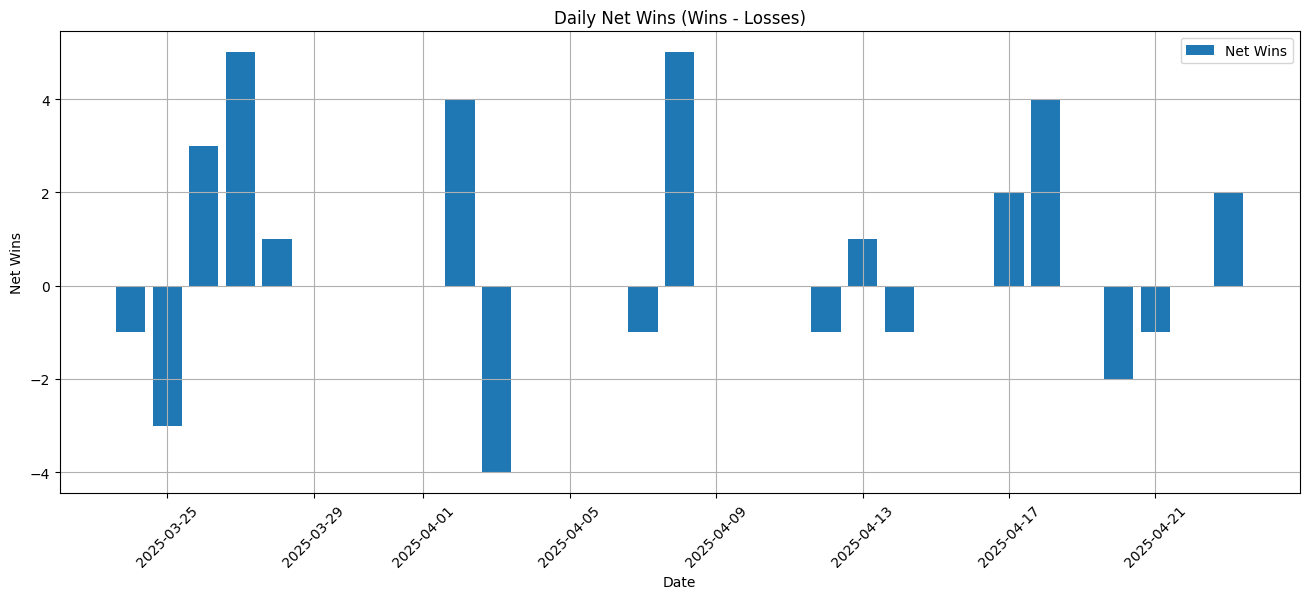

In [75]:
plt.figure(figsize=(16, 6))
plt.bar(daily_stats.index, daily_stats['Net Wins'], label='Net Wins')
plt.gca().set(title='Daily Net Wins (Wins - Losses)', xlabel='Date', ylabel='Net Wins')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid()
plt.show()

top 3 days by net wins

In [87]:
netWins = daily_stats.sort_values(by='Net Wins' ,ascending=False)
netWins.head(3)

Result,Loss,Win,Net Wins
Date,,,
2025-04-08,0,5,5
2025-03-27,0,5,5
2025-04-02,2,6,4


total wins and losses:

In [97]:
# wins
totalWins = daily_stats['Win'].sum()
print("Total Wins:", totalWins)

# losses
totalLosses = daily_stats['Loss'].sum()
print("Total losses:", totalLosses)

# win ratio
totalGames = len(df30)
winRatio = (totalWins / totalGames) * 100
print(f"Win Rate: {winRatio:.2f}%")

Total Wins: 65
Total losses: 52
Win Rate: 55.56%


<BarContainer object of 22 artists>

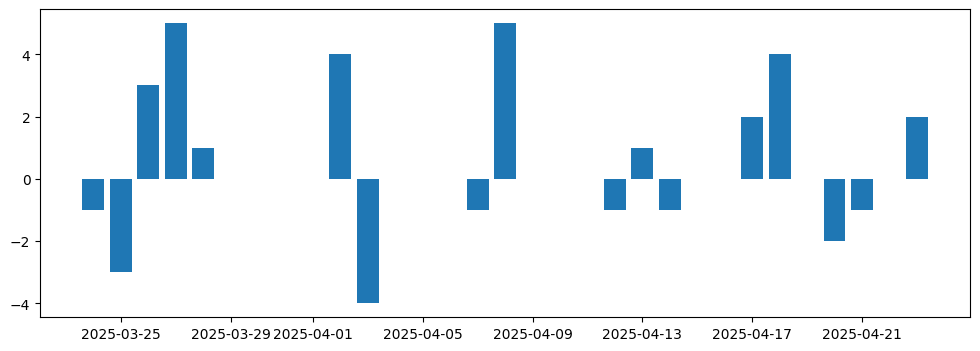

In [ ]:
plt.figure(figsize=(12,4))
plt.bar(netWins.index, netWins['Net Wins'])
plt.gca().set(title='Daily Net Wins (Wins - Losses)', xlabel='Date', ylabel='Net Wins')


### high scores

most kills in a game

most deaths

most assists

In [36]:
# 3 highest kills
df['Kills'].sort_values(ascending=False).head(3)

Date
Jun 24, 2024    33
Jul 4, 2024     33
Jun 27, 2024    33
Name: Kills, dtype: int64

In [37]:
# 3 highest deaths
df['Deaths'].sort_values(ascending=False).head(3)

Date
Feb 25, 2025    22
Mar 7, 2025     21
Feb 17, 2025    18
Name: Deaths, dtype: int64

In [38]:
# 3 highest Assists
df['Assists'].sort_values(ascending=False).head(3)

Date
Oct 25, 2024    38
Mar 23, 2025    32
Mar 11, 2025    30
Name: Assists, dtype: int64

### CONTINUE:

- Pull more data
- Clean up
- Better visualization